# Fiddle with the EAWAG scans
Look at the orientation and see if we can do some cropping based on landmarks.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import k3d
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
import skimage
from tqdm.auto import tqdm, trange
import math
from numcodecs import Blosc

In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to F:\tmp


In [3]:
from dask.distributed import Client
client = Client()

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 255.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63648,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 255.70 GiB
Comm: tcp://127.0.0.1:63716,Total threads: 4
Dashboard: http://127.0.0.1:63718/status,Memory: 31.96 GiB
Nanny: tcp://127.0.0.1:63653,


In [5]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [6]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [7]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (8, 4.5)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [8]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [9]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [10]:
# Different locations if running either on Linux or Windows
FastSSD = True
overthere = False  # Load the data directly from the iee-research_storage drive
nanoct = True  # Load the data directly from the 2214
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if not overthere:
    Root = os.path.join(BasePath, 'EAWAG')
else:
    Root = BasePath
# if overthere:
#         Root = os.path.join('I:\\microCTupload')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\EAWAG


In [11]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [12]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [13]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [14]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [15]:
# Get *all* log files, unsorted but fast
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [16]:
print('We found %s log files in %s' % (len(Data), Root))

We found 446 log files in F:\EAWAG


In [17]:
# Limit *all* the data to only the 'head' scans
Data = Data[Data['LogFile'].str.contains('head')]

In [18]:
print('We have %s log files with "head" in their name in %s' % ((len(Data)), Root))

We have 383 log files with "head" in their name in F:\EAWAG


In [19]:
# Generate folder name
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [20]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [21]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [22]:
Data.tail()

,LogFile,Folder,Fish,Scan
94,F:\EAWAG\TJ2\head\rec\TJ2_rec.log,F:\EAWAG\TJ2\head\rec,TJ2,head_rec
95,F:\EAWAG\TJ3\head\rec\TJ3_rec.log,F:\EAWAG\TJ3\head\rec,TJ3,head_rec
96,F:\EAWAG\TMG15\head\rec\TMG15_rec.log,F:\EAWAG\TMG15\head\rec,TMG15,head_rec
97,F:\EAWAG\TS03\head\rec\TS03_rec.log,F:\EAWAG\TS03\head\rec,TS03,head_rec
98,F:\EAWAG\ZuOS115\head\rec\ZuOS115_rec.log,F:\EAWAG\ZuOS115\head\rec,ZuOS115,head_rec


In [23]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [[os.path.join(root, name)
                            for root, dirs, files in os.walk(f)
                            for name in files
                            if 'rec0' in name and name.endswith((".png"))] for f in Data['Folder']]
# Count how many files we have
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [24]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c, row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions in %s' % ((len(Data)), Root))

We have 98 folders with reconstructions in F:\EAWAG


In [25]:
# Get parameters we need from the log files
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [26]:
# Load all reconstructions into DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/98 [00:00<?, ?it/s]

In [27]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [28]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [29]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [30]:
# Read in previously generated MIPs or calculate them
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(), desc='Calculating MIPs', total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s: %s' % (row['Fish'], row['Scan'], direction),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute().squeeze()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

Calculating MIPs:   0%|          | 0/98 [00:00<?, ?it/s]

10151/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103375/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103571/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103635/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103704/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103718/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103723/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103754/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103761/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103767/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103767/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103778/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103908/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104016/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104021/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104061/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10448/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10448/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104621/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104671/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104671/head_rec2: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104856/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104929/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10605/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10618/head_head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10618/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_2xbin_23um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_4xbin_40um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_unbinned_17.5um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_13um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_18um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10629/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

106641/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

106816/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10791/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10794/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109188/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109209/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109220/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109320/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11053/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11116/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11116/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11322/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11344/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11447/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11500/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11557/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11601/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11639/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11729/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11807/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11807/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11946/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11965/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11965/rec_head_40um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11992/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12319/head_30um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12319/head_50um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12807/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13069/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13115/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

131282/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13393/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13492/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

14295/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

14298/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

156645/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

158795/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

158816/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

161476/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

161543/head_30um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22406/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22476/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22476/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

AN33/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

BH58/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG104/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG142/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG156/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG161/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG75/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG80/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG92/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG96/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

JU22/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

KAT13/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

KC31/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

MA31/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

NA4/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

NY75/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TJ2/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TJ3/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TMG15/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TS03/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

ZuOS115/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
# Collect views
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of MIP images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        print('%s/%s: %s' % (c, len(Data), os.path.join(row.Fish, row.Scan)))
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Fish'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s MIP' % direction)
            plt.axis('off')
            plt.title('%s\n%s MIP' % (os.path.join(row['Fish'], row['Scan']), direction))
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

Saving overview of MIP images:   0%|          | 0/98 [00:00<?, ?it/s]

The functions below were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [32]:
# From Hearts-Melly/SubMyocardAnalysis.ipynb
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return(properties)

In [33]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert(labels.max() != 0)  # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:]) + 1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [34]:
def threshold(image, verbose=False):
    # Calculate threshold of image where image is non-zero
    threshold = skimage.filters.threshold_otsu(image[image > 0])
    if verbose:
        plt.subplot(121)
        plt.imshow(image)
        plt.imshow(dask.array.ma.masked_equal(image > threshold, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.subplot(122)
        plt.semilogy(histogram(image), label='Log-Histogram')
        plt.axvline(threshold, label='Otsu threshold: %s' % threshold)
        plt.legend()
        plt.show()
    return(threshold)

In [35]:
# Calculate the histogram of an image
# We can safely assume to only use 8bit images
def histogram(img):
    histogram, bins = dask.array.histogram(dask.array.array(img),
                                           bins=2**8,
                                           range=[0, 2**8])
    return(histogram)

In [36]:
whichone = 4
print(os.path.join(Data.Fish[whichone], Data.Scan[whichone]))
img = dask.array.asarray(Data.MIP_Anteroposterior[whichone])

103704\head_rec


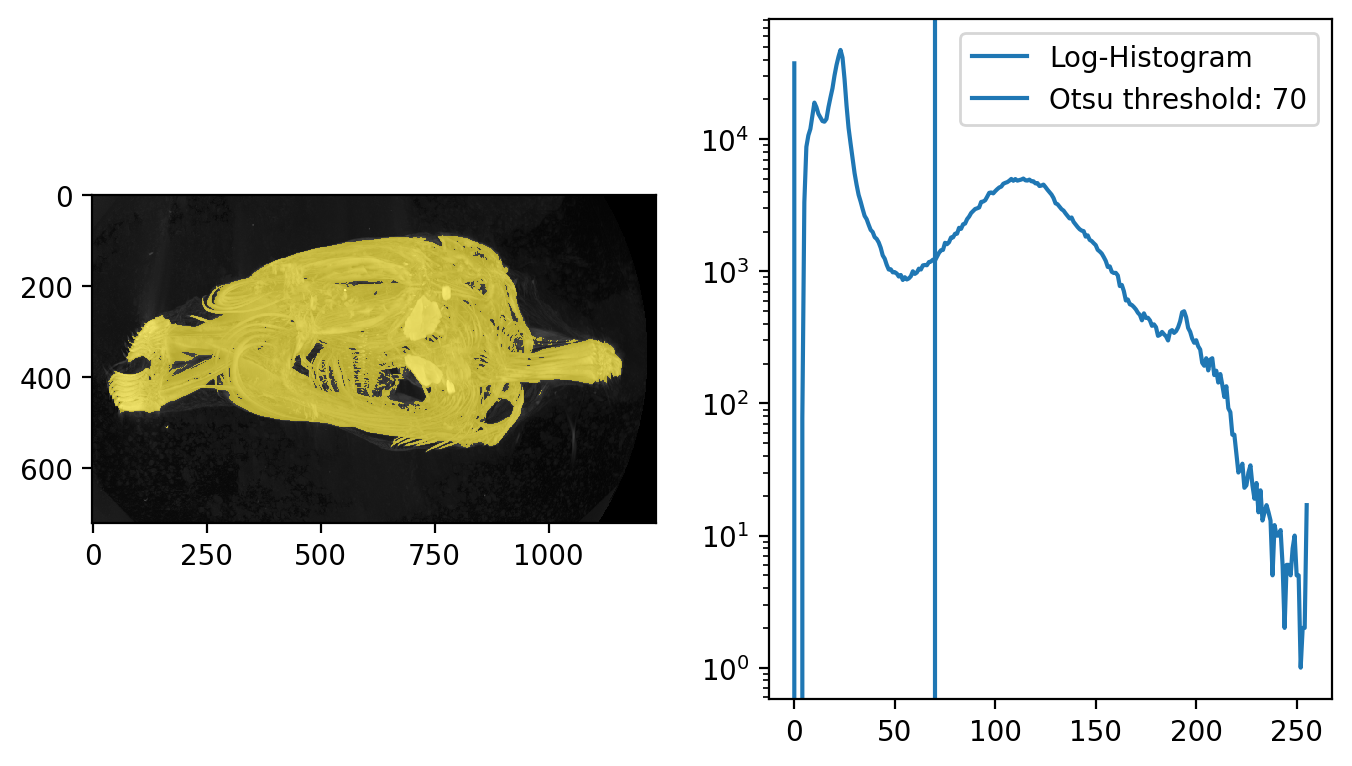

In [37]:
t = threshold(img.compute(), verbose=True)

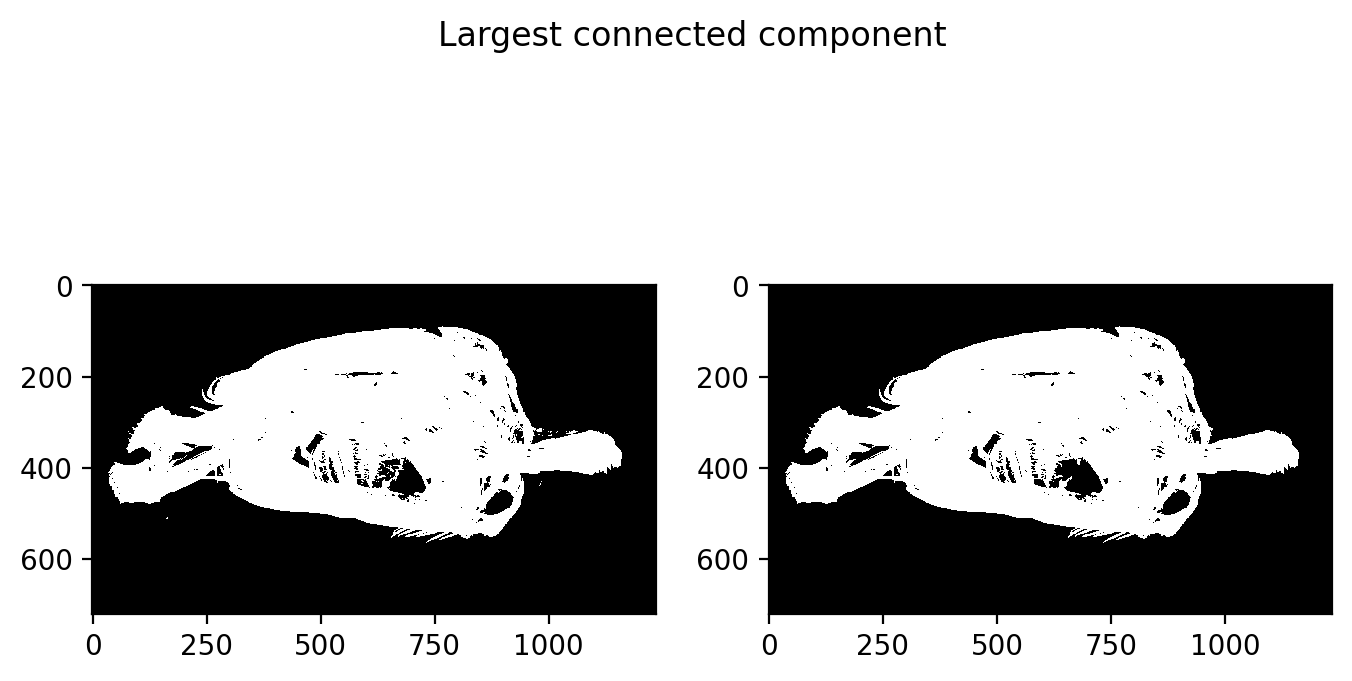

In [38]:
a = get_largest_region(img > t, verbose=True)

In [39]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return((x0, y0))

In [40]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=False)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return(cx, cy)

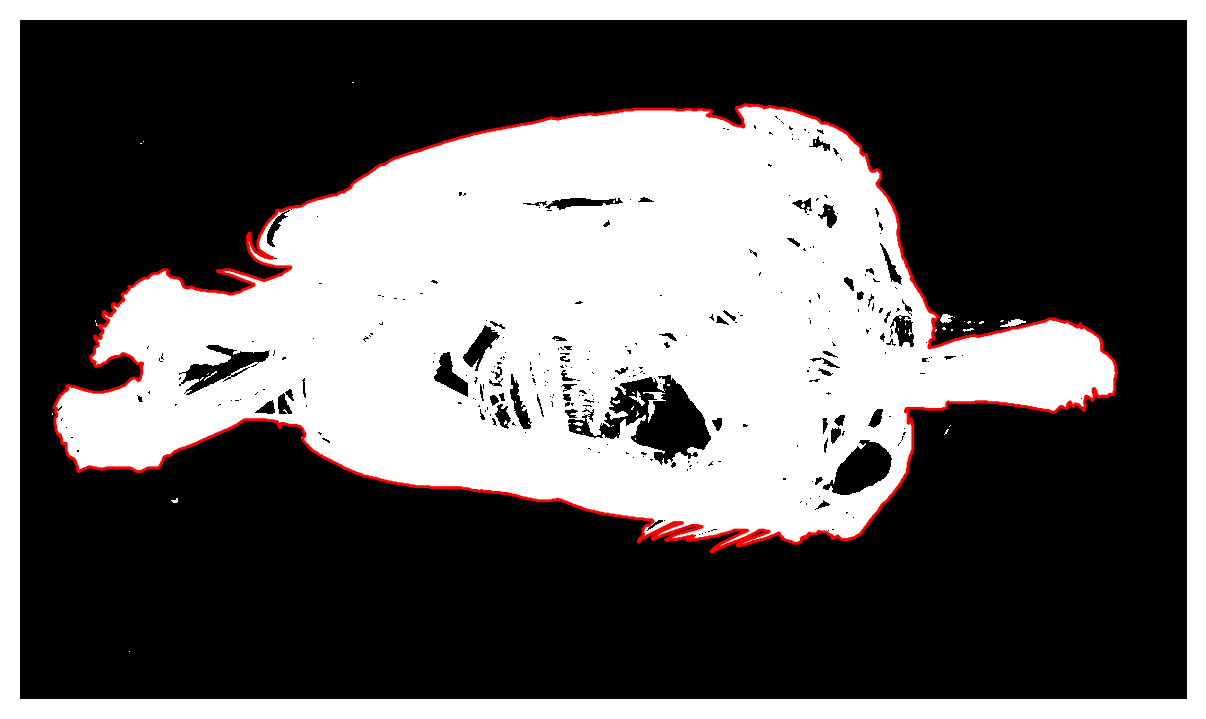

In [41]:
contour = get_contour(img > t, verbose=True)

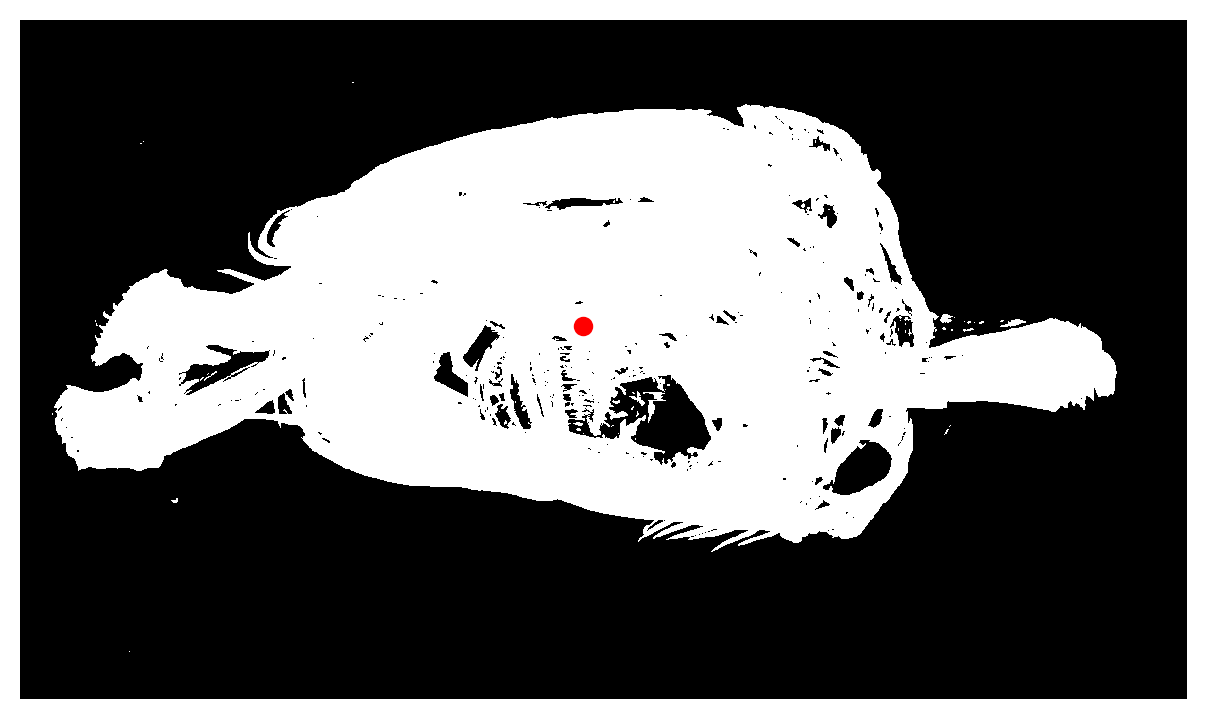

In [42]:
centroid = get_centroid(img > t, verbose=True)

In [43]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return()

In [44]:
def get_orientation(img, voxelsize, length=10, verbose=False):
    '''
    Get and draw orientation onto image, with a (default) length of 10 mm
    '''
    props = get_properties(img)
    whichlengthdowewant = length
    reallength = whichlengthdowewant / voxelsize * 1000  # mm
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation']) * reallength
    y1 = y0 - math.sin(props['orientation']) * reallength
    x2 = x0 - math.sin(props['orientation']) * reallength
    y2 = y0 - math.cos(props['orientation']) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s mm long orientation bars' % length)
        plt.show()
    return(x0, x1, x2, y0, y1, y2)

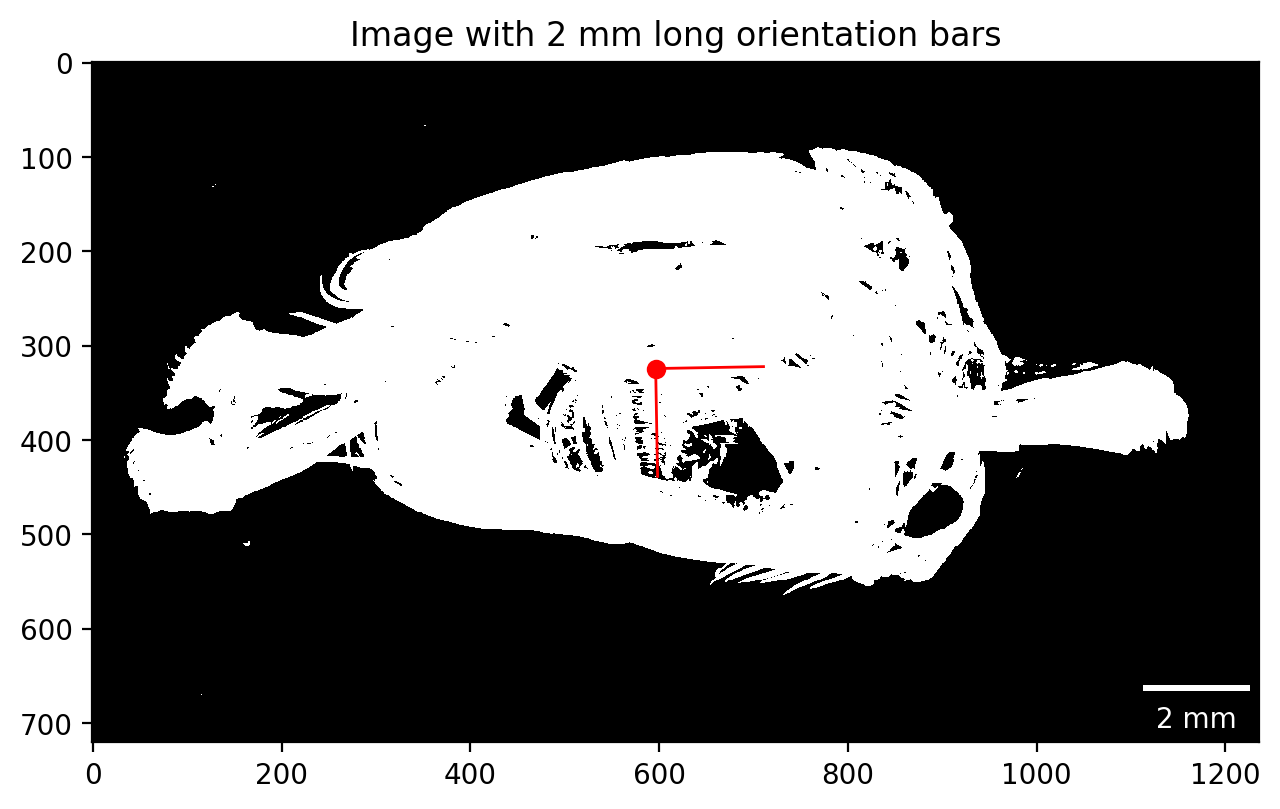

In [45]:
x0, x1, x2, y0, y1, y2 = get_orientation(img > t,
                                         Data.Voxelsize[4],
                                         length=2,
                                         verbose=True)

The functions above were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [46]:
a = get_properties(img > t)
print(a)

   index  label  centroid-0  centroid-1    area     perimeter  orientation
0      1      2  324.253949  596.418522  291397  11580.966948    -1.552971


In [47]:
# Use the angle and centroid to rotate image
img_rotated = numpy.empty_like(img)
img_rotated = skimage.transform.rotate(img.compute(),
                                       angle=numpy.rad2deg(a.orientation[0]),
                                       center=(a['centroid-0'][0], a['centroid-1'][0]),
                                       preserve_range=True)

In [48]:
numpy.rad2deg(a.orientation[0])+90

1.0212998747194888

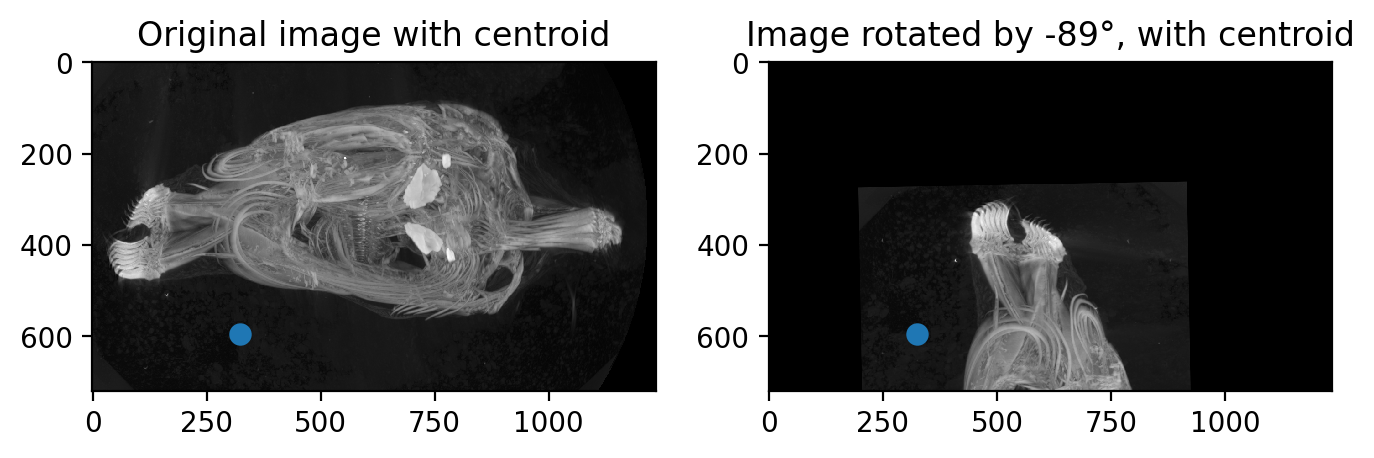

In [49]:
# Let's show what we did
plt.subplot(121)
plt.imshow(img)
plt.scatter(a['centroid-0'], a['centroid-1'], s=50)
plt.title('Original image with centroid')
plt.subplot(122)
plt.imshow(img_rotated)
plt.scatter(a['centroid-0'], a['centroid-1'], s=50)
plt.title('Image rotated by %0.f°, with centroid' % numpy.rad2deg(a.orientation[0]))
plt.show()

Figure out the otolith position on each of the directional views.

In [50]:
def smoother(curve, frac=0.1):
    ''' Smooth a curve '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=frac)
    return(smoothed)

In [51]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    minimal_diff = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(minimal_diff, c='r', label='Border')
        plt.legend()
    return(minimal_diff)

In [52]:
def get_maximum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    maximal_diff = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(maximal_diff, c='r', label='Border')
        plt.legend()
    return(maximal_diff)

In [53]:
def get_peak(curve, frac=0.1, verbose=False):
    '''
    Very simple function to detect the peak on a the gray value along an image.
    '''
    smoothed = smoother(curve, frac=frac)
    peak_index = numpy.argmax(smoothed)
    peak_value = smoothed[peak_index]
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(peak_index, c='r', label='Peak @ %s' % peak_index)
        plt.axhline(peak_value, c='g', label='Peak value %s' % peak_value)
        plt.legend()
    return(peak_index, peak_value)

In [54]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly. From https://stackoverflow.com/a/50011743/323100"""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [55]:
def get_grayvalues(image, direction, which):
    ''' get grayvalue along horizontal or vertical image axis '''
    grayvalues = []
    if direction == 'horizontal':
        ax = 0
    elif direction == 'vertical':
        ax = 1
    else:
        print('No direction given, specify either "direction=horizontal" or "direction=vertical"')
        print('Returning EMPTY grayvalues')        
        return(grayvalues)
    if which == 'sum':
        grayvalues = image.sum(axis=ax)
    elif which == 'max':
        grayvalues = image.max(axis=ax)
    else:
        print('No method given, specify either "which=max" or "which=sum"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    return(grayvalues)

In [56]:
for dir in directions:
    print(dir)

Anteroposterior
Lateral
Dorsoventral


In [59]:
view = ['horizonta', 'vertical']

In [60]:
def otolither_region(whichone, discard_front=None, bottom=1000, showregion=True, verbose=False):
    '''
    Modeled after algorithm for finding the enamel/dentin border for the tooth project (https://github.com/habi/zmk-tooth-cohort/blob/master/ToothAnalysis.ipynb), we
    look for a change and bump in the gray values along different axis of the fishes.
    This works out nicely to detect the approximate region of the otoliths.
    '''
    if verbose:
        print('We try to find the otholith for the %s scan of fish %s' % (Data.Scan[whichone], Data.Fish[whichone]))
    
    # Discard some regiomns for the fishes:
    # frotntally: contains the teeth)
    # back: can contain labels or dorsal fins
    discard_front = Data.MIP_Lateral[whichone].shape[0]//4
    discard_back = Data.MIP_Lateral[whichone].shape[0]//6
    # bottom: a lot of the fish, no otolith
    # top: often empty
    discard_bottom = Data.MIP_Anteroposterior[whichone].shape[1]//3
    discard_top = Data.MIP_Anteroposterior[whichone].shape[1]//5
    # laterally otoliths are in the middle of the fish
    discard_lateral = Data.MIP_Lateral[whichone].shape[1]//10
    
    if verbose:
        print('We discard the ventral %s and the dorsal %s slices' % (discard_bottom, discard_top))
        print('We discard the anterior %s and the posterior %s slices' % (discard_front, discard_back))
        print('We discard %s laterally on both sides' % (discard_lateral))
    
    for direction in directions:
        print(direction, Data['MIP_' + direction][whichone].shape)

    # AP view
    grayvalues_ap_horizontal = get_grayvalues(Data.MIP_Anteroposterior[whichone][:,discard_bottom:-discard_top], direction='horizontal', which='sum')
    otolith_peak_ap_horizontal, otolith_peak_value_ap = peak(smoother(grayvalues_ap_horizontal))
    otolith_diff_min_ap = get_minimum(grayvalues_ap_horizontal)    
    otolith_diff_max_ap = get_maximum(grayvalues_ap_horizontal)
    position_dorsal = otolith_diff_max_ap + discard_front
    position_ventral = otolith_peak_ap_horizontal + (otolith_peak_ap_horizontal - position_dorsal)        

    # Lateral view
    grayvalues_lt_vertical = get_grayvalues(Data.MIP_Lateral[whichone][discard_front:-discard_back,:], direction='vertical', which='sum')
    otolith_peak_lt_vertical, otolith_peak_value_lt_vertical = peak(grayvalues_lt_vertical)
    otolith_diff_min_lt = get_minimum(grayvalues_lt_vertical)
    otolith_diff_max_lt = get_maximum(grayvalues_lt_vertical)
    position_front = otolith_diff_max_lt + discard_front
    position_back = otolith_peak_lt_vertical + (otolith_peak_lt_vertical - position_front)
       
    # DV view
    grayvalues_dv_vertical = get_grayvalues(Data.MIP_Dorsoventral[whichone][discard_front:-discard_back,:], direction='vertical', which='sum')
    otolith_peak_dv_vertical, otolith_peak_value_dv = peak(smoother(grayvalues_dv_vertical))
    otolith_diff_min_dv = get_minimum(grayvalues_dv_vertical[discard_front:])    
    otolith_diff_max_dv = get_maximum(grayvalues_dv_vertical[discard_front:])
    position_dv_discard_front = otolith_diff_max_dv + discard_front
    position_dv_stop = otolith_peak_dv_vertical + (otolith_peak_dv_vertical - position_dv_discard_front)
    
    if verbose:
        # Display everything
        # In the same order as the MIPs collections
        # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(1, 3)
        mip_anteroposterior = fig.add_subplot(gs[:, 0])
        plt.imshow(Data.MIP_Anteroposterior[whichone])
        plt.fill_betweenx(range(Data.MIP_Anteroposterior[whichone].shape[0]),
                          0, discard_bottom,
                          alpha=0.309, label='discarded up to %s' % (discard_bottom),
                          facecolor=seaborn.color_palette()[0])
        plt.fill_betweenx(range(Data.MIP_Anteroposterior[whichone].shape[0]),
                          Data.MIP_Anteroposterior[whichone].shape[1] - discard_top, Data.MIP_Anteroposterior[whichone].shape[1] -1,
                          alpha=0.309, label='discarded from %s' % (Data.MIP_Anteroposterior[whichone].shape[1] - discard_top),
                          facecolor=seaborn.color_palette()[0])
    
        plt.fill_between(range(Data.MIP_Anteroposterior[whichone].shape[1]),
                         0, discard_lateral,
                         alpha=0.309, label='discarded up to %s' % (discard_lateral),
                         facecolor=seaborn.color_palette()[2])
        plt.fill_between(range(Data.MIP_Anteroposterior[whichone].shape[1]),
                         Data.MIP_Anteroposterior[whichone].shape[0] - discard_lateral, Data.MIP_Anteroposterior[whichone].shape[0] -  1,
                         alpha=0.309, label='discarded from %s' % (Data.MIP_Lateral[whichone].shape[0] - discard_lateral),
                         facecolor=seaborn.color_palette()[2])
        
        #plt.plot(range(discard_bottom, discard_bottom+len(grayvalues_ap_horizontal)), rescale_linear(grayvalues_ap_horizontal, 1, Data.MIP_Anteroposterior[whichone].shape[0] - 1))
        #plt.plot(rescale_linear(smoother(grayvalues_ap_horizontal), 1, Data.MIP_Anteroposterior[whichone].shape[0] - 1))
        #plt.axvline(discard_bottom + otolith_diff_max_ap, label='Max diff@%s' % (discard_front + otolith_diff_max_ap), color=seaborn.color_palette()[2])
        #plt.axvline(otolith_peak_ap_horizontal, label='Peak@%s' % otolith_peak_ap_horizontal, color=seaborn.color_palette()[3])
        #plt.axvline(discard_bottom + otolith_diff_min_ap, label='Min diff@%s' % (discard_front + otolith_diff_min_ap), color=seaborn.color_palette()[4])
        plt.legend(loc='lower left')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[0]))
        plt.title('MIP Anteroposterior')       
        
        mip_lateral = fig.add_subplot(gs[:, 1])
        plt.imshow(Data.MIP_Lateral[whichone])
        plt.fill_between(range(Data.MIP_Lateral[whichone].shape[1]),
                         0, discard_front,
                         alpha=0.309, label='discarded up to %s' % (discard_front),
                         facecolor=seaborn.color_palette()[0])
#         plt.fill_between(range(Data.MIP_Lateral[whichone].shape[1]),
#                          Data.MIP_Lateral[whichone].shape[0] - discard_back, Data.MIP_Lateral[whichone].shape[0] -  1,
#                          alpha=0.309, label='discarded from %s' % (Data.MIP_Lateral[whichone].shape[0] - discard_back),
#                          facecolor=seaborn.color_palette()[0])
        
#         plt.fill_betweenx(range(Data.MIP_Lateral[whichone].shape[0]),
#                           0, discard_bottom,
#                           alpha=0.309, label='discarded up to %s' % (discard_bottom))
#         plt.fill_betweenx(range(Data.MIP_Lateral[whichone].shape[4]),
#                           Data.MIP_Anteroposterior[whichone].shape[1] - discard_top, Data.MIP_Anteroposterior[whichone].shape[1] -1,
#                           alpha=0.309, label='discarded from %s' % (Data.MIP_Anteroposterior[whichone].shape[1] - discard_top),
#                           facecolor=seaborn.color_palette()[4])

        plt.plot(rescale_linear(grayvalues_lt_vertical, 1, Data.MIP_Lateral[whichone].shape[1] - 1),
                 range(discard_front,discard_front+len(grayvalues_lt_vertical)))
        #plt.plot(rescale_linear(smoother(grayvalues_lt_vertical), 1, Data.MIP_Lateral[whichone].shape[1] - 1)[discard_front:],
        #         range(discard_front,Data.MIP_Lateral[whichone].shape[0]))
        #plt.axhline(discard_front + otolith_diff_max_lt, label='Max diff@%s' % (discard_front + otolith_diff_max_lt), color=seaborn.color_palette()[2])
        #plt.axhline(otolith_peak_lt_vertical, label='Peak@%s' % otolith_peak_lt_vertical, color=seaborn.color_palette()[3])
        #plt.axhline(discard_front + otolith_diff_min_lt, label='Min diff@%s' % (discard_front + otolith_diff_min_lt), color=seaborn.color_palette()[4])
        #plt.fill_between(range(Data.MIP_Lateral[whichone].shape[1]), position_front, position_back, alpha=0.5)
        plt.legend(loc='upper left')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[1]))
        plt.title('MIP Lateral')
        
        mip_dorsoventral = fig.add_subplot(gs[:, 2])
        plt.imshow(Data.MIP_Dorsoventral[whichone])
        plt.fill_betweenx(range(Data.MIP_Dorsoventral[whichone].shape[0]),
                          0, discard_lateral,
                          alpha=0.309, label='discarded to %s' % (discard_lateral),
                          facecolor=seaborn.color_palette()[4])
        plt.fill_betweenx(range(Data.MIP_Dorsoventral[whichone].shape[0]),
                          Data.MIP_Dorsoventral[whichone].shape[1] - discard_lateral, Data.MIP_Dorsoventral[whichone].shape[1] -1,
                          alpha=0.309, label='discarded after %s' % (Data.MIP_Dorsoventral[whichone].shape[1] - discard_lateral),
                          facecolor=seaborn.color_palette()[4])
        
        plt.fill_between(range(Data.MIP_Dorsoventral[whichone].shape[1]),
                         0, discard_front,
                         alpha=0.309, label='discarded up to %s' % (discard_front),
                         facecolor=seaborn.color_palette()[1])
        plt.fill_between(range(Data.MIP_Dorsoventral[whichone].shape[1]),
                         Data.MIP_Lateral[whichone].shape[0] - discard_back, Data.MIP_Lateral[whichone].shape[0] -  1,
                         alpha=0.309, label='discarded from %s' % (Data.MIP_Lateral[whichone].shape[0] - discard_back),
                         facecolor=seaborn.color_palette()[1])

        plt.plot(rescale_linear(grayvalues_dv_vertical, 1, Data.MIP_Dorsoventral[whichone].shape[1] - 1),
                 range(discard_front, discard_front + len(grayvalues_dv_vertical)))
        #plt.plot(rescale_linear(smoother(grayvalues_dv_vertical[discard_front:]), 1, Data.MIP_Dorsoventral[whichone].shape[1] - 1),
        #         range(discard_front,Data.MIP_Dorsoventral[whichone].shape[0]))
        #plt.axhline(discard_front + otolith_diff_max_dv, label='Max diff@%s' % (discard_front + otolith_diff_max_dv), color=seaborn.color_palette()[2])
        #plt.axhline(otolith_peak_dv_vertical, label='Peak@%s' % otolith_peak_dv_vertical, color=seaborn.color_palette()[3])
        #plt.axhline(discard_front + otolith_diff_min_dv, label='Min diff@%s' % (discard_front + otolith_diff_min_dv), color=seaborn.color_palette()[4])
        #plt.fill_between(range(Data.MIP_Dorsoventral[whichone].shape[1]), position_dv_discard_front, position_dv_stop, alpha=0.5)
        plt.legend(loc='upper center')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[2]))        
        plt.title('MIP Dorsoventral')  
        
        plt.show()
    region = [position_front, position_back]
    print('CORRECT THEM LABELS!')
    return(region)

In [69]:
# Generate empty columns
for c, direction in enumerate(directions):
    Data['Discard_' + direction] = ''
    for view in ('horizontal', 'vertical'):    
        Data['Otolith_Peak_' + direction + '_' + view] = ''
        Data['Otolith_Max_' + direction + '_' + view] = ''
        Data['Otolith_Min_' + direction + '_' + view] = ''    
        Data['Grayvalues_' + direction + '_' + view] = ''

In [70]:
def otolither_region(whichone, discard_front=None, bottom=1000, showregion=True, verbose=False):
    '''
    Modeled after algorithm for finding the enamel/dentin border for the tooth project (https://github.com/habi/zmk-tooth-cohort/blob/master/ToothAnalysis.ipynb), we
    look for a change and bump in the gray values along different axis of the fishes.
    This works out nicely to detect the approximate region of the otoliths.
    '''
    if verbose:
        print('We try to find the otholith for the %s scan of fish %s' % (Data.Scan[whichone], Data.Fish[whichone]))
    
    # Discard some regions of the images
    # frontally: contains the teeth
    # back: can contain labels or dorsal fins
    Data.at[whichone, 'Discard_Anteroposterior'] = [Data.MIP_Lateral[whichone].shape[0] // 3,
                                                    Data.MIP_Lateral[whichone].shape[0] - Data.MIP_Lateral[whichone].shape[0] // 5]
    # laterally otoliths are in the middle of the fish    
    Data.at[whichone, 'Discard_Lateral'] = [Data.MIP_Dorsoventral[whichone].shape[1] // 6,
                                            Data.MIP_Dorsoventral[whichone].shape[1] - Data.MIP_Dorsoventral[whichone].shape[1] // 6]
    # bottom: a lot of the fish, no otolith
    # top: often empty
    Data.at[whichone, 'Discard_Dorsoventral'] = [Data.MIP_Anteroposterior[whichone].shape[1] // 3,
                                                 Data.MIP_Anteroposterior[whichone].shape[1] - Data.MIP_Anteroposterior[whichone].shape[1]//4]
    
    # if verbose:
    #     print('We discard the ventral %s and the dorsal %s slices' % (Data['Discard_Dorsoventral'][whichone][0], Data['Discard_Dorsoventral'][whichone][1]))
    #     print('We discard the anterior %s and the posterior %s slices' % (Data['Discard_Anteroposterior'][whichone][0], Data['Discard_Anteroposterior'][whichone][1]))
    #     print('We discard %s laterally on both sides' % Data['Discard_Lateral'][whichone])
    
    for view in ('horizontal', 'vertical'):
        for direction in directions:
            Data.at[whichone, 'Grayvalues_' + direction + '_' + view] = get_grayvalues(Data['MIP_' + direction][whichone],
                                                                                       direction=view,
                                                                                       which='sum')
    for view in ('horizontal', 'vertical'):
        for direction in directions:
            Data.at[whichone, 'Otolith_Peak_' + direction + '_' + view] = get_peak(Data['Grayvalues_' + direction + '_' + view][whichone])
    return()

In [71]:
def display_otolith_position(whichone):
    # Display everything
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3)
    for c, direction in enumerate(directions):
        mip = fig.add_subplot(gs[0, c])
        plt.imshow(Data['MIP_' + direction][whichone])
        if not 'Dorsoventral' in direction:
            plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
                              0, Data['Discard_Dorsoventral'][whichone][0],
                              alpha=0.309, label='discarded up to %s' % Data['Discard_Dorsoventral'][whichone][0],
                              facecolor=seaborn.color_palette()[2])
            plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
                              Data['Discard_Dorsoventral'][whichone][1], Data['MIP_' + direction][whichone].shape[1] - 1,
                              alpha=0.309, label='discarded from %s' % Data['Discard_Dorsoventral'][whichone][1],
                              facecolor=seaborn.color_palette()[2])
        else:
            plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
                              0, Data['Discard_Lateral'][whichone][0],
                              alpha=0.309, label='discarded up to %s' % Data['Discard_Lateral'][whichone][0],
                              facecolor=seaborn.color_palette()[1])
            plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
                              Data['Discard_Lateral'][whichone][1], Data['MIP_' + direction][whichone].shape[1] - 1,
                              alpha=0.309, label='discarded from %s' % Data['Discard_Lateral'][whichone][1],
                              facecolor=seaborn.color_palette()[1])
        if 'Ante' not in direction:
            plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                             0,
                             Data['Discard_Anteroposterior'][whichone][0],
                             alpha=0.309, label='discarded from %s' % Data['Discard_Anteroposterior'][whichone][0],
                             facecolor=seaborn.color_palette()[0])
            plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                             Data['Discard_Anteroposterior'][whichone][1],
                             Data['MIP_' + direction][whichone].shape[0] - 1,
                             alpha=0.309, label='discarded from %s' % Data['Discard_Anteroposterior'][whichone][1],
                             facecolor=seaborn.color_palette()[0])
        else:
            plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                             0,
                             Data['Discard_Lateral'][whichone][0],
                             alpha=0.309, label='discarded from %s' % Data['Discard_Lateral'][whichone][0],
                             facecolor=seaborn.color_palette()[1])
            plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                             Data['Discard_Lateral'][whichone][1],
                             Data['MIP_' + direction][whichone].shape[0] - 1,
                             alpha=0.309, label='discarded from %s' % Data['Discard_Lateral'][whichone][1],
                             facecolor=seaborn.color_palette()[1])
        plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichone], 0, Data['MIP_' + direction][whichone].shape[0] - 1),
                 label='horizontal', color='gray')
        plt.plot(rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichone]), 0, Data['MIP_' + direction][whichone].shape[0] - 1),
                 label='horizontal', color='lightgray')
        plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_vertical'][whichone], 0, Data['MIP_' + direction][whichone].shape[1] - 1),
                 range(Data['MIP_' + direction][whichone].shape[0]),
                 label='vertical', color='gray')
        plt.plot(rescale_linear(smoother(Data['Grayvalues_' + direction + '_vertical'][whichone]), 0, Data['MIP_' + direction][whichone].shape[1] - 1),
                 range(Data['MIP_' + direction][whichone].shape[0]),
                 label='vertical', color='lightgray')
        if 'Ante' in direction:
            plt.axvline(get_peak(Data['Grayvalues_' + direction + '_horizontal'][whichone])[0],
                       label='DV Otolith @ %s' % get_peak(Data['Grayvalues_' + direction + '_horizontal'][whichone])[0])
        else:
            plt.axhline(get_peak(Data['Grayvalues_' + direction + '_vertical'][whichone])[0],
                        label='AP Otolith @ %s' % get_peak(Data['Grayvalues_' + direction + '_vertical'][whichone])[0])
        # plt.legend(loc='lower left')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[c]))
        plt.title('%s MIP\nwith a size of %s x %s px' % (direction, Data['MIP_' + direction][whichone].shape[0], Data['MIP_' + direction][whichone].shape[1]))
        mip = fig.add_subplot(gs[1, c])
        plt.imshow(Reconstructions[whichone][Data['Discard_Anteroposterior'][whichone][0]:Data['Discard_Anteroposterior'][whichone][1],
                                             Data['Discard_Lateral'][whichone][0]:Data['Discard_Lateral'][whichone][1],
                                             Data['Discard_Dorsoventral'][whichone][0]:Data['Discard_Dorsoventral'][whichone][1]
                                            ].max(axis=c))
        plt.title('%s Otolith region' % (direction))
    plt.show()
    return()

We try to find the otholith for the head_rec scan of fish 103635


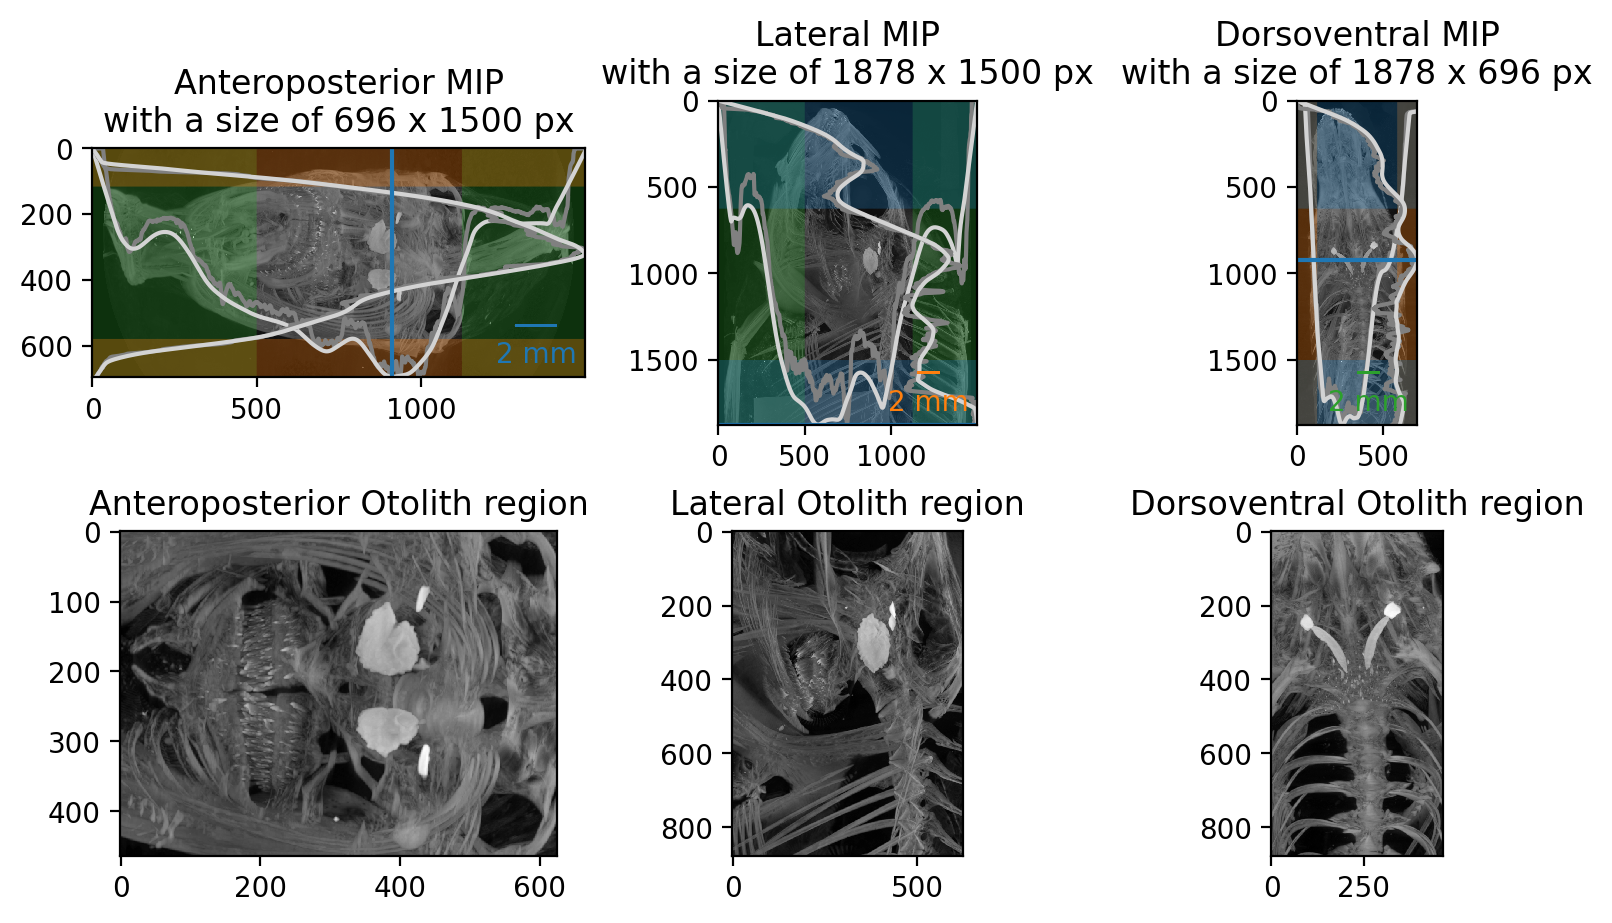

()

In [74]:
whichone = 3
otolither_region(whichone, verbose=True)
display_otolith_position(whichone)

In [75]:
for whichone, row in tqdm(Data.iterrows(),
                          desc='Extracting otolith regions',
                          total=len(Data)):
    otolither_region(whichone, verbose=False)

Extracting otolith regions:   0%|          | 0/98 [00:00<?, ?it/s]

In [76]:
# for whichone, row in tqdm(Data.iterrows(),
#                           desc='Displaying otolith regions',
#                           total=len(Data)):
#     display_otolith_position(whichone)

In [81]:
# Save out otolith regions as .zarr files
Data['OutputNameOtolithRegion'] = [os.path.join(os.path.dirname(f), 'otolith.region.zarr') for f in Data['Folder']]
for whichone, row in tqdm(Data.iterrows(),
                          desc='Extracting otolith regions to .zarr files',
                          total=len(Data)):
    if not os.path.exists(row['OutputNameOtolithRegion']):
        Reconstructions[whichone][Data['Discard_Anteroposterior'][whichone][0]:Data['Discard_Anteroposterior'][whichone][1],
                                             Data['Discard_Lateral'][whichone][0]:Data['Discard_Lateral'][whichone][1],
                                             Data['Discard_Dorsoventral'][whichone][0]:Data['Discard_Dorsoventral'][whichone][1]
                                            ].to_zarr(row['OutputNameOtolithRegion'],
                                                      overwrite=True,
                                                      compressor=Blosc(cname='zstd',
                                                                       shuffle=Blosc.BITSHUFFLE))

Extracting otolith regions to .zarr files:   0%|          | 0/98 [00:00<?, ?it/s]

In [127]:
# Load the otoliths in again
Otoliths = [dask.array.from_zarr(file) for file in Data['OutputNameOtolithRegion']]

In [128]:
# View one otolith in 3D

In [129]:
whichone = 0

In [130]:
subsample = 2

In [135]:
# threshold = threshold(Otoliths[whichone], verbose=False)
# histogram = histogram(Otoliths[whichone])

TypeError: 'numpy.int32' object is not callable

In [ ]:
plt.semilogy(histogram)
plt.axvline(threshold, label='Threshold @%s' % threshold)
plt.legend()
plt.show()

In [150]:
# Load into K3D
plt_volume = k3d.volume(Otoliths[whichone][::subsample,::subsample,::subsample].astype(numpy.float16), color_range=[threshold,Otoliths[whichone].max().compute()])

In [151]:
# Display the otolith
plot = k3d.plot()
plot += plt_volume
plot.display()

Output()

In [ ]:
asdfasdfsda=

In [ ]:
# plot5 = k3d.get_plot()
# plot5.snapshot_type = 'inline'
# plot5.display()

# data = plot5.get_snapshot()

# with open('snapshot_inline.html', 'w') as f:
#     f.write(data)

In [ ]:
for c, row in Data.iterrows():
    print(row.Fish, row.Folder)
    otolither_region(c, verbose=True)

In [ ]:
whichone = 5
out = Reconstructions[5][716:1009+716-500,300:-300,800:1000]

In [ ]:
out.shape

In [ ]:
plt.imshow(out.max(axis=0))

In [ ]:
# Make a column for saving the otolith positions
for d, direction in enumerate(directions):
    Data['Otholith_Positions_' + direction] = ''
    Data['Otholith_Position_Mean_' + direction] = ''

In [ ]:
# Detect otolith positions
for c, row in Data.iterrows():
    print('Finding otolith position for %s/%s' % (row.Fish, row.Scan))
    for d, direction in enumerate(directions):
        Data.at[c, 'Otholith_Positions_' + direction] = otolither(row['MIP_' + direction], sigma=11, verbose=True)

In [ ]:
# Save us the mean position
for d, direction in enumerate(directions):
    Data['Otholith_Position_Mean_' + direction] = [(numpy.mean(op[0]),
                                                    numpy.mean(op[1])) for op in Data['Otholith_Positions_' + direction]]

In [ ]:
for i in Data['Otholith_Positions_Lateral']:
    print(round(numpy.mean(i[0])),
          round(numpy.mean(i[1])))

In [ ]:
for i in Data['Otholith_Position_Mean_Lateral']:
    print(round(i[0]), round(i[1]))

In [ ]:
for whichone in range(len(Data)):
    print(whichone, os.path.join(Data.Fish[whichone], Data.Scan[whichone]))

In [ ]:
direction = 'Lateral'

In [ ]:
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.title([round(i) for i in row['Otholith_Position_Mean_' + direction]])
        plt.axhline(row['Otholith_Position_Mean_' + direction][1])
        plt.axvline(row['Otholith_Position_Mean_' + direction][0])
        plt.suptitle('%s/%s' % (row.Fish, row.Scan))
        plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
    plt.show()

In [ ]:
# Detect otolith position by looking for maximum gray value along fish
for d, direction in enumerate(directions):
    Data['GrayValueAlong_' + direction] = ''
    Data['Otolith_MIP_Position_' + direction] = ''
for whichone, row in Data.iterrows():
    for d, direction in enumerate(directions):
        # Calculate gray value sum along fish.
        Data.at[whichone, 'GrayValueAlong_' + direction] = dask.array.sum(Data['MIP_' + direction][whichone],
                                                                          axis=1)
        # Maximum of this shoud give us the otolith position
        Data.at[whichone,
                'Otolith_MIP_Position_' + direction] = dask.array.argmax(dask.array.sum(Data['MIP_' + direction][whichone],
                                                                                        axis=1))
        # Plot what we found
        plt.subplot(1, 3, d + 1)
        plt.imshow(Data['MIP_' + direction][whichone])
        # Plot the *rescaled* values over the image
        plt.plot(rescale_linear(Data['GrayValueAlong_' + direction][whichone],
                                100,
                                Data['MIP_' + direction][whichone].shape[1] - 100),
                 range(len(Data['GrayValueAlong_' + direction][whichone])),
                 label='Normalized gray value sum along fish',
                 color=seaborn.color_palette()[0])
        plt.axhline(Data['Otolith_MIP_Position_' + direction][whichone],
                    label='Max@%s' % Data['Otolith_MIP_Position_' + direction][whichone].compute(),
                    color=seaborn.color_palette()[1])
        plt.title('%s MIP' % direction)
        plt.suptitle('%s/%s: MIPs of %s/%s' % (whichone, len(Data), Data.Fish[whichone], Data.Scan[whichone]))
        plt.legend(loc='lower center')
    plt.show()

In [ ]:
for c, row in Data.iterrows():
    print(c, len(Data), os.path.join(row.Fish, row.Scan))
    print('\t Otolith from MIP',
          row['Otolith_MIP_Position_Anteroposterior'].compute(),
          row['Otolith_MIP_Position_Lateral'].compute(),
          row['Otolith_MIP_Position_Dorsoventral'].compute())
    print('\t Otolith from otholither function',
          row['Otholith_Position_Mean_Anteroposterior'],
          row['Otholith_Position_Mean_Lateral'],
          row['Otholith_Position_Mean_Dorsoventral'])

In [ ]:
whichone = 3

In [ ]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(Data['MIP_' + direction][whichone])
    # From otholither function
    plt.axhline(Data['Otholith_Position_Mean_' + direction][whichone][1],
                label='otholither mean position 1: %s' % round(Data['Otholith_Position_Mean_' + direction][whichone][1]),
                color=seaborn.color_palette()[0])
    plt.axvline(Data['Otholith_Position_Mean_' + direction][whichone][0],
                label='otholither mean posistion 0: %s' % round(Data['Otholith_Position_Mean_' + direction][whichone][0]),
                color=seaborn.color_palette()[1])
    # From sum along axis
    plt.axhline(Data['Otolith_MIP_Position_' + direction][whichone],
                label='MIP sum: %s' % Data['Otolith_MIP_Position_' + direction][whichone].compute(),
                color=seaborn.color_palette()[3])
    plt.legend(loc='lower center')
    plt.title(direction)
    plt.suptitle('%s/%s' % (Data.Fish[whichone], Data.Scan[whichone]))
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um'))
plt.show()

In [ ]:
for direction in directions:
    print(direction, Data['MIP_' + direction][whichone].shape)

In [ ]:
for direction in directions:
    print(direction, Data['Otholith_Position_Mean_' + direction][whichone])

In [ ]:
for direction in directions:
    print(direction, round(Data['Otolith_MIP_Position_' + direction][whichone].compute()))

In [ ]:
# CAN WE CALCULATE BOTH DV and THE LT POSITION ON THE AP MIP?

In [ ]:
# Get us positions of otolith in relation to original data
position_ap = numpy.mean((Data['Otholith_Position_Mean_Lateral'][whichone][1],
                          Data['Otholith_Position_Mean_Dorsoventral'][whichone][1],
                          Data['Otolith_MIP_Position_Lateral'][whichone],
                          Data['Otolith_MIP_Position_Dorsoventral'][whichone]),
                         dtype='int')
# laterally, we assume the center of the image for now
# position_lt = numpy.mean((Data['Otholith_Position_Mean_' + direction][whichone][1],
#                           Data['Otolith_MIP_Position_' + direction][whichone]),dtype='int')
position_lt = Data.MIP_Dorsoventral[whichone].shape[1] // 2
position_dv = numpy.mean((Data['Otholith_Position_Mean_Anteroposterior'][whichone][0],
                          Data['Otholith_Position_Mean_Lateral'][whichone][0]),
                         dtype='int')

In [ ]:
print(position_ap)
print(position_lt)
print(position_dv)

In [ ]:
slicethickness = 250

In [ ]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(Data['MIP_' + direction][whichone])
    if c == 0:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_lt - slicethickness // 2,
                         position_lt + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_dv - slicethickness // 2, position_dv + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    elif c == 1:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_ap - slicethickness // 2,
                         position_ap + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_dv - slicethickness // 2, position_dv + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    else:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_ap - slicethickness // 2,
                         position_ap + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_lt - slicethickness // 2, position_lt + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    plt.title(direction)
    plt.suptitle('%s/%s' % (Data.Fish[whichone], Data.Scan[whichone]))
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um'))
    
outfilepath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                           '%s.%s.Otolither.png' % (Data['Fish'][whichone], Data['Scan'][whichone]))
if not os.path.exists(outfilepath):
    plt.savefig(outfilepath,
                oarent=True,
                bbox_inches='tight')
    print('Figure saved to %s' % outfilepath)
plt.show()

In [ ]:
print(position_ap)
print(position_lt)
print(position_dv)

In [ ]:
# Grab region calculated above from reconstructions
otolithregion = Reconstructions[whichone][position_ap - slicethickness // 2:position_ap + slicethickness // 2,
                                          position_lt - slicethickness // 2:position_lt + slicethickness // 2,
                                          position_dv - slicethickness // 2:position_dv + slicethickness // 2
                                         ]
for ax in range(3):
    plt.subplot(1, 3, ax + 1)
    plt.imshow(dask.array.max(otolithregion, axis=ax))
    plt.suptitle('%s/%s: MIP from AP %s:%s, LT %s:%s, DV %s:%s' % (Data.Fish[whichone],
                                                                   Data.Scan[whichone],
                                                                   position_ap - slicethickness // 2, position_ap + slicethickness // 2,
                                                                   position_lt - slicethickness // 2, position_lt + slicethickness // 2,
                                                                   position_dv - slicethickness // 2, position_dv + slicethickness // 2))
plt.show()

In [ ]:
threshold(otolithregion.compute())

In [ ]:
threshold(otolithregion[otolithregion > 42].compute())

In [ ]:
plt.imshow(otolithregion[slicethickness//2])
plt.imshow(dask.array.ma.masked_equal(otolithregion[slicethickness//2] > 102,0), cmap='viridis', alpha=0.5)

In [ ]:
# import pickle

In [ ]:
# file = open('largest', 'wb')
# pickle.dump(largest,file)
# file.close()

In [ ]:
# file = open('largest', 'rb')
# largest = pickle.load(file)
# file.close()

In [ ]:
# largest.shape

In [ ]:
# # Make file smaller for testing reasons
# subsample = 4
# largest_smaller = largest[::subsample, ::subsample, ::subsample]
# largest_smaller.shape

In [ ]:
subsample = 2

In [ ]:
vmin = threshold(otolithregion.compute())
print(vmin)

In [ ]:
# Load into K3D
plt_volume = k3d.volume(dask.array.ma.masked_less(otolithregion,102)[::subsample, ::subsample, ::subsample].astype(numpy.float16))

In [ ]:
# Display the otolith
plot = k3d.plot()
plot += plt_volume
plot.display()    

In [ ]:
# plot5 = k3d.get_plot()
# plot5.snapshot_type = 'inline'
# plot5.display()

# data = plot5.get_snapshot()

# with open('snapshot_inline.html', 'w') as f:
#     f.write(data)